# Exploratory Data Analysis

### Content
#### MDS Quality Measures Dataset
- [Import Necessary Modules and Dataset](#import&data)
- [Heatmap: Measure Codes](#relationAS)
- [Empirical Cumulative Distribution Function](#ecdf)
- [Permutation Test](#hypothesis)
- [States PCA](#pca)

#### Provider Information Dataset
- [Download and Analyze Provider Information Dataset](#down)
- [Automation to Convert Dtypes](#dtypes)
- [Heatmap: Numeric Variables](#heatmap)
- [State PCA](#pca1)
- [Uniform Distribution Testing](#edf1)

# MDS Quality Measure Dataset

### Import Necessary Modules and Datasets <a id = 'import&data'></a>

In [1]:
# Import tools to get datasets
from io import BytesIO
from zipfile import ZipFile
import urllib

# Import data manipulation and plot modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import missingno as msno

# Import EDA tools
from sklearn.decomposition import PCA
import pandas_profiling
from scipy import stats

In [2]:
# Unzip and read cleaned dataset
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/clean_quality.csv.zip?raw=true')
file = ZipFile(BytesIO(url.read()))
qfile = file.open("clean_quality.csv")
clean_quality = pd.read_csv(qfile, encoding='cp1252').rename(columns = 
                            {'Four Quarter Average Score':'score'}).drop('Unnamed: 0',axis=1)
file.close()

### Heatmap: Measure Code <a id='relationAS'></a>

In [3]:
n = len(clean_quality.columns)
clean_quality = pd.get_dummies(clean_quality,columns=['Measure Code'])

In [4]:
print(clean_quality['Measure Description'].unique())

['Percentage of long-stay residents whose need for help with daily activities has increased'
 'Percentage of long-stay residents who lose too much weight'
 'Percentage of low risk long-stay residents who lose control of their bowels or bladder'
 'Percentage of long-stay residents with a catheter inserted and left in their bladder'
 'Percentage of long-stay residents with a urinary tract infection'
 'Percentage of long-stay residents experiencing one or more falls with major injury'
 'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine'
 'Percentage of long-stay residents who received an antipsychotic medication'
 'Percentage of short-stay residents assessed and appropriately given the pneumococcal vaccine'
 'Percentage of long-stay residents whose ability to move independently worsened'
 'Percentage of long-stay residents who received an antianxiety or hypnotic medication'
 'Percentage of high risk long-stay residents with pressure ulcers'
 'Perc

In [5]:
replace = ['activities',
           'weight',
           'bowels',
           'catheter',
           'urinary infection',
           'injury',
           'long pneumococcal vaccine',
           'long antipsychotic',
           'short pneumococcal vaccine',
           'paralysis',
           'antianxiety',
           'pressure ulcers',
           'long influenza vaccine',
           'function',
           'short influenza vaccine',
           'depressive',
           'short antipsychotic',
           'physically restrained']

In [6]:
for i in enumerate(clean_quality.iloc[:,n-1:].columns):
    clean_quality = clean_quality.rename(columns={i[1]:replace[i[0]]})

In [7]:
# Combine short and long. Long and short are not needed when we have resident type
clean_quality['antipsychotic'] = clean_quality[['short antipsychotic','long antipsychotic']].sum(axis=1)
clean_quality['influenza vaccine'] = clean_quality[['short influenza vaccine','long influenza vaccine']].sum(axis=1)
clean_quality['pneumococcal vaccine'] = clean_quality[['short pneumococcal vaccine','long pneumococcal vaccine']].sum(axis=1)
clean_quality = clean_quality.drop(['short antipsychotic','long antipsychotic','short influenza vaccine',
              'long influenza vaccine','short pneumococcal vaccine',
              'long pneumococcal vaccine'], axis = 1)

In [8]:
# All is good.
display(clean_quality.iloc[:,n-1:].describe())

,activities,weight,bowels,catheter,urinary infection,injury,paralysis,antianxiety,pressure ulcers,function,depressive,physically restrained,antipsychotic,influenza vaccine,pneumococcal vaccine
count,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000,235265.000000
mean,0.062542,0.061484,0.060800,0.050641,0.054726,0.048924,0.062058,0.062882,0.042612,0.062763,0.063167,0.062946,0.112103,0.123248,0.069105
std,0.242138,0.240216,0.238963,0.219264,0.227444,0.215709,0.241261,0.242752,0.201980,0.242537,0.243264,0.242866,0.315494,0.328723,0.253633
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


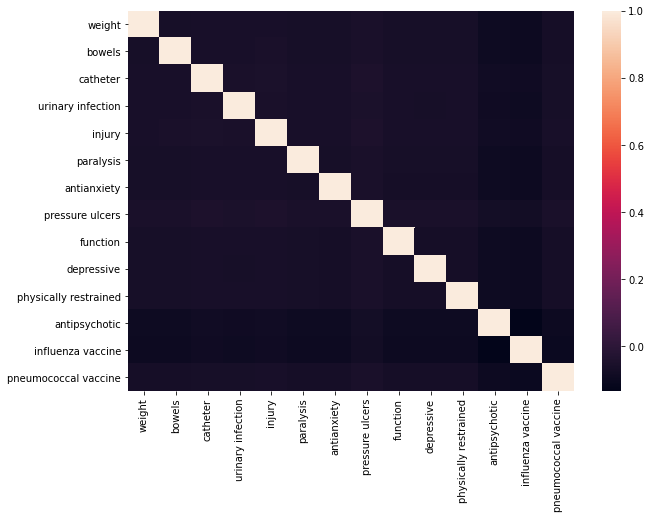

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(clean_quality.iloc[:,n:].corr())
plt.show()

In [10]:
# Measure Description and Measure Code are not necessary
clean_quality = clean_quality.drop('Measure Description',axis=1)

### Empirical Cumulative Distribution Function <a id='ecdf'></a>

In [11]:
# Write the ECDF function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x, y

In [12]:
# ECDF all Four Quarter Average Score and Q1-Q4 Score
xq, yq = ecdf(clean_quality ['score']/100)

Given that the limited dependent variable is ∈(0,1) and cross-sectional, the continuous version of Binomial Distribution needs to be in use to determine whether not or the empirical distribution is non-parametric. This continuous version is called Beta Distribution. The bootstrapping versions of formulas are in use for the scenario where expected value and variance are known but $\alpha$ and $\beta$ are unknown (Sinharay, 2010).

The bootstrapping versions of formulas are similar to:

$\hat\alpha = \bar x \left[\frac{\bar x (1- \bar x)}{s^2 - 1}\right]$

$\hat\beta = (1- \bar x) \left[ \frac{\bar x (1- \bar x)}{s^2-1} \right]$

### Reference:

-------

Sinharay, S. (2010). The International Encyclopedia of Education. In P. Penelope, E. Baker, & B. McGaw (Eds). *Continuous Probability Distribution* (3rd ed., pp. 98 - 102). Elsevier. https://doi.org/10.1016/B978-0-08-044894-7.01720-6 

--------------

In [13]:
## Create function to calculate alpha and beta
def alpha(data):
    # Mean and Variance
    x = np.mean(data)
    s2 = np.var(data,ddof=1)
    # Alpha
    alpha = np.abs(x*(x*(1-x)/(s2-1)))
    return alpha

def beta(data):
    # Find mean and var
    x = np.mean(data)
    s2 = np.var(data,ddof=1)
    # Find beta
    beta = np.abs((1-x)*(x*(1-x)/(s2-1)))
    return beta

In [14]:
# Set random seed
np.random.seed(56)

# Create Beta Distributions for one-rounded year score and Q1-Q4 scores
xq_theo, yq_theo = ecdf(np.random.beta(alpha(clean_quality['score']/100),
               beta(clean_quality['score']/100),size=100000))

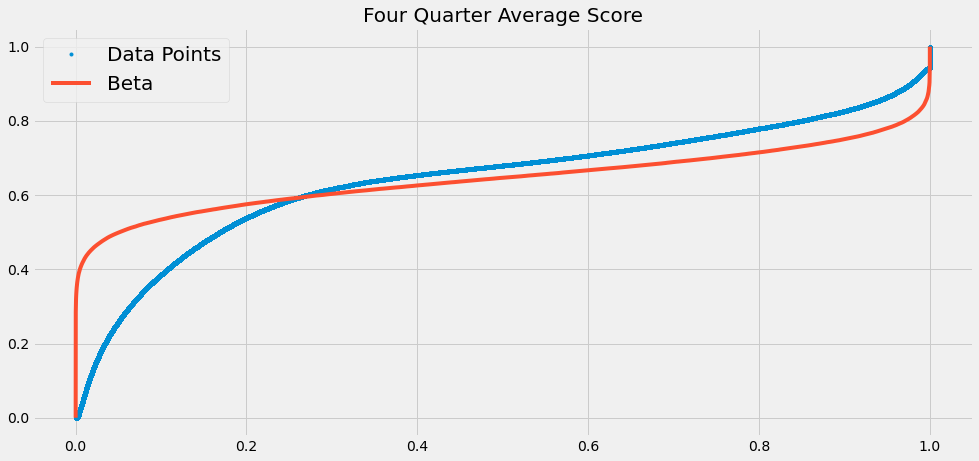

In [15]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 7))

plt.plot(xq,yq,marker = '.',linestyle = 'none')
plt.plot(xq_theo,yq_theo)
plt.title('Four Quarter Average Score',fontsize=20)
plt.legend(('Data Points','Beta'),fontsize=20)

plt.show()

When the alpha and beta are parameterized, the theoretical beta cumulative distribution is inconsistent with not only `Four Quarter Average Score` ECDF but all Q1-Q4 ECDFs. In other words, the area between curves is higher than zero due to wide gap between empirical and theoretical distributions. In other words, the non-parameteric procedure test called permutation test needs to be in use in order to test several hypotheses. For causal analysis, the non-parametric regression should be in use.

### Permutation Test <a id='hypothesis'></a>

In [16]:
def permutation_test(data, target_column = 'score', separate_by = 'column', separate_value = 0, size = 10000):
    # Observed difference
    observed_diff = np.mean(data[data[separate_by] == separate_value][target_column]) - np.mean(data[
        data[separate_by] != separate_value][target_column])
    # Instantiate the list and permutation loop
    diff = []
    for i in range(size):
        perm_result = np.random.RandomState(seed = i+1).permutation(data[target_column])
        diff.append(np.mean(perm_result[data[separate_by] == separate_value])-np.mean(
            perm_result[data[separate_by] != separate_value]))
    
    # Find the p-value where random difference is equal to or larger than observed difference
    pvalue = np.sum(np.abs(diff) >= np.abs(observed_diff))/len(data)
    
    return pvalue

In [17]:
# Focus on Relationship between Four Quarter Average Score and Measure Codes
labels = []
counters = []
p_values = []
for i in clean_quality.iloc[:,n:]:
    perm_test = clean_quality[['score', i]]
    labels.append(i)
    counters.append(Counter(perm_test[i]))
    p_values.append(permutation_test(perm_test, target_column = 'score', 
                 separate_by = i, separate_value = 0, size = 1000))

display(pd.DataFrame({'Variable':labels,'Counter':counters,'p_value':p_values}))

,Variable,Counter,p_value
0,bowels,"{0: 220961, 1: 14304}",0.000000
1,catheter,"{0: 223351, 1: 11914}",0.000000
2,urinary infection,"{0: 222390, 1: 12875}",0.000000
3,injury,"{0: 223755, 1: 11510}",0.000000
4,paralysis,"{0: 220665, 1: 14600}",0.000000
5,antianxiety,"{0: 220471, 1: 14794}",0.000000
6,pressure ulcers,"{0: 225240, 1: 10025}",0.000000
7,function,"{0: 220499, 1: 14766}",0.000000
8,depressive,"{0: 220404, 1: 14861}",0.000000
9,physically restrained,"{0: 220456, 1: 14809}",0.000000


The alpha level with Bonferroni correction is 0.05 divided by 13 tests equal to 0.0038.

### States PCA <a id='pca'></a>

In [18]:
# Binarize categorical datatype
clean_quality = pd.concat([clean_quality.drop('Used in Quality Measure Five Star Rating', axis = 1),
                     pd.get_dummies(clean_quality['Used in Quality Measure Five Star Rating'],
                     drop_first=True)],axis=1)
clean_quality = pd.concat([clean_quality.drop('Resident type', axis = 1),
                     pd.get_dummies(clean_quality['Resident type'],
                     drop_first=True)],axis=1)

clean_quality = clean_quality.rename(columns = {'Y':'Used in Quality Meaure Five Star Rating'})

In [19]:
# Select the columns for state summary
n = [3,5]
n.extend(list(range(7,len(clean_quality.columns))))
state_summary = clean_quality.iloc[:,n]

In [20]:
# Transform data and store score in another object
df = state_summary.groupby('Provider State').mean()
score = df.score/100
df = df.drop('score',axis=1)

In [21]:
# PCA fit transform
pca = PCA().fit(df)

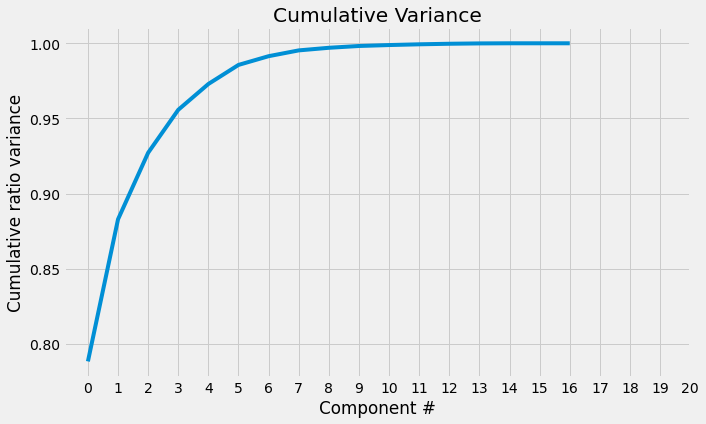

In [22]:
plt.subplots(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.xticks(np.arange(0, 21, step=1))
plt.title('Cumulative Variance')
plt.show()

In [23]:
pca_df = pd.DataFrame(pca.transform(df), index = list(df.index))

In [24]:
# Change from 0 - 15 to pc_1 to pc_16
thelist = []
for i in pca_df.columns:
    thelist.append('pc_'+str(i+1))
pca_df.columns = thelist

In [25]:
pca_df = pd.concat([score,pca_df],axis=1)
pca_df['score'] = pca_df['score']*3000

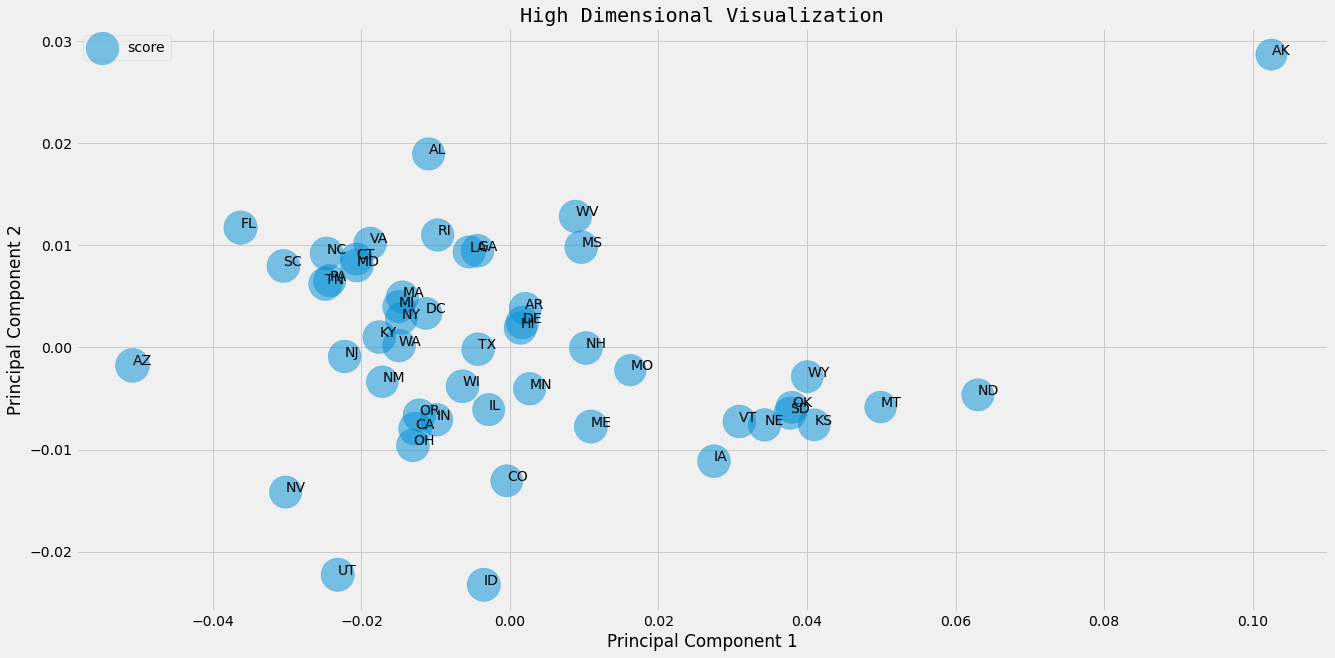

In [26]:
x = pca_df.pc_1
y = pca_df.pc_2
state = pca_df.index
plt.subplots(figsize=(20,10))
plt.scatter('pc_1','pc_2', s = 'score', data=pca_df, alpha=0.5, label = 'score')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('High Dimensional Visualization',family = 'monospace')
plt.legend()
plt.show()

The Alaska state is outlier based on regressors.

# Provider Information Dataset

### Download and Analyze the Provider Information Dataset <a id = 'down'></a>

In [27]:
# Unzip and read cleaned dataset
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/information.csv.zip?raw=true')
file = ZipFile(BytesIO(url.read()))
qfile = file.open("information.csv")
information = pd.read_csv(qfile, encoding='cp1252').drop('Unnamed: 0',axis=1)
file.close()

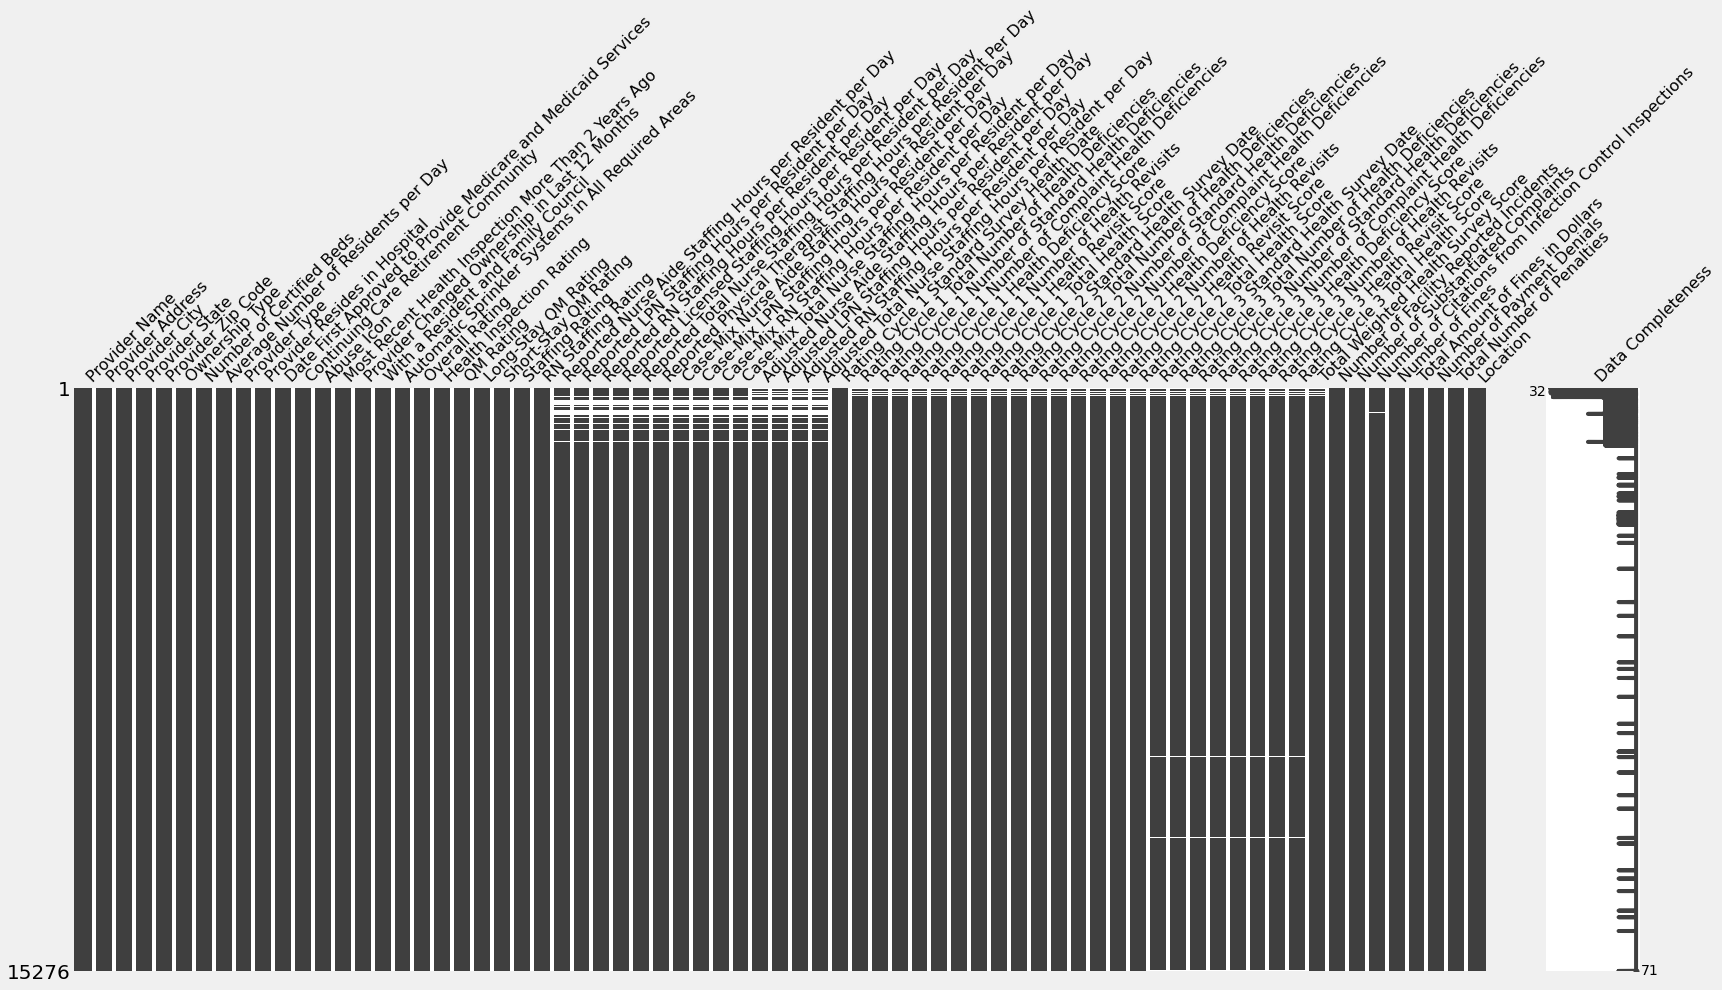

In [28]:
msno.matrix(information, labels = True)
plt.show()

As indicated by the matrix, this is possible that missing columns are at same rows.

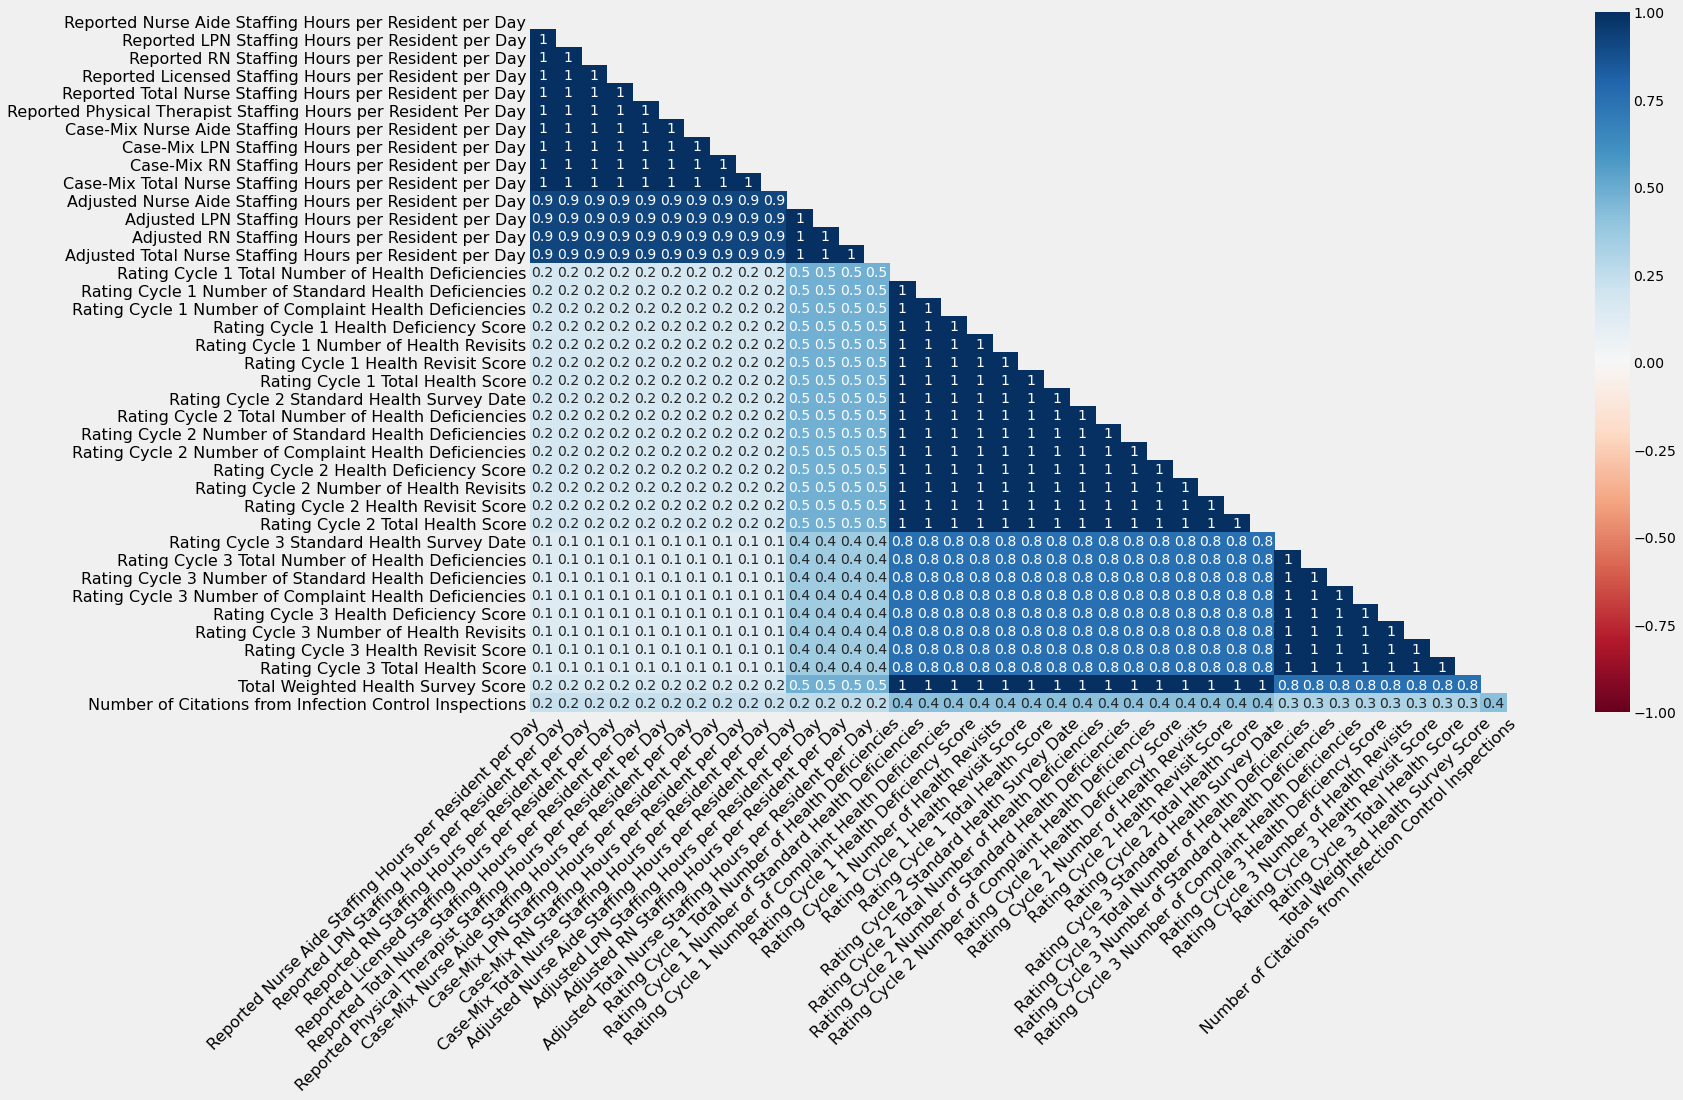

In [29]:
msno.heatmap(information)
plt.show()

As indicated by heatmap, it confirms my suspicion. 

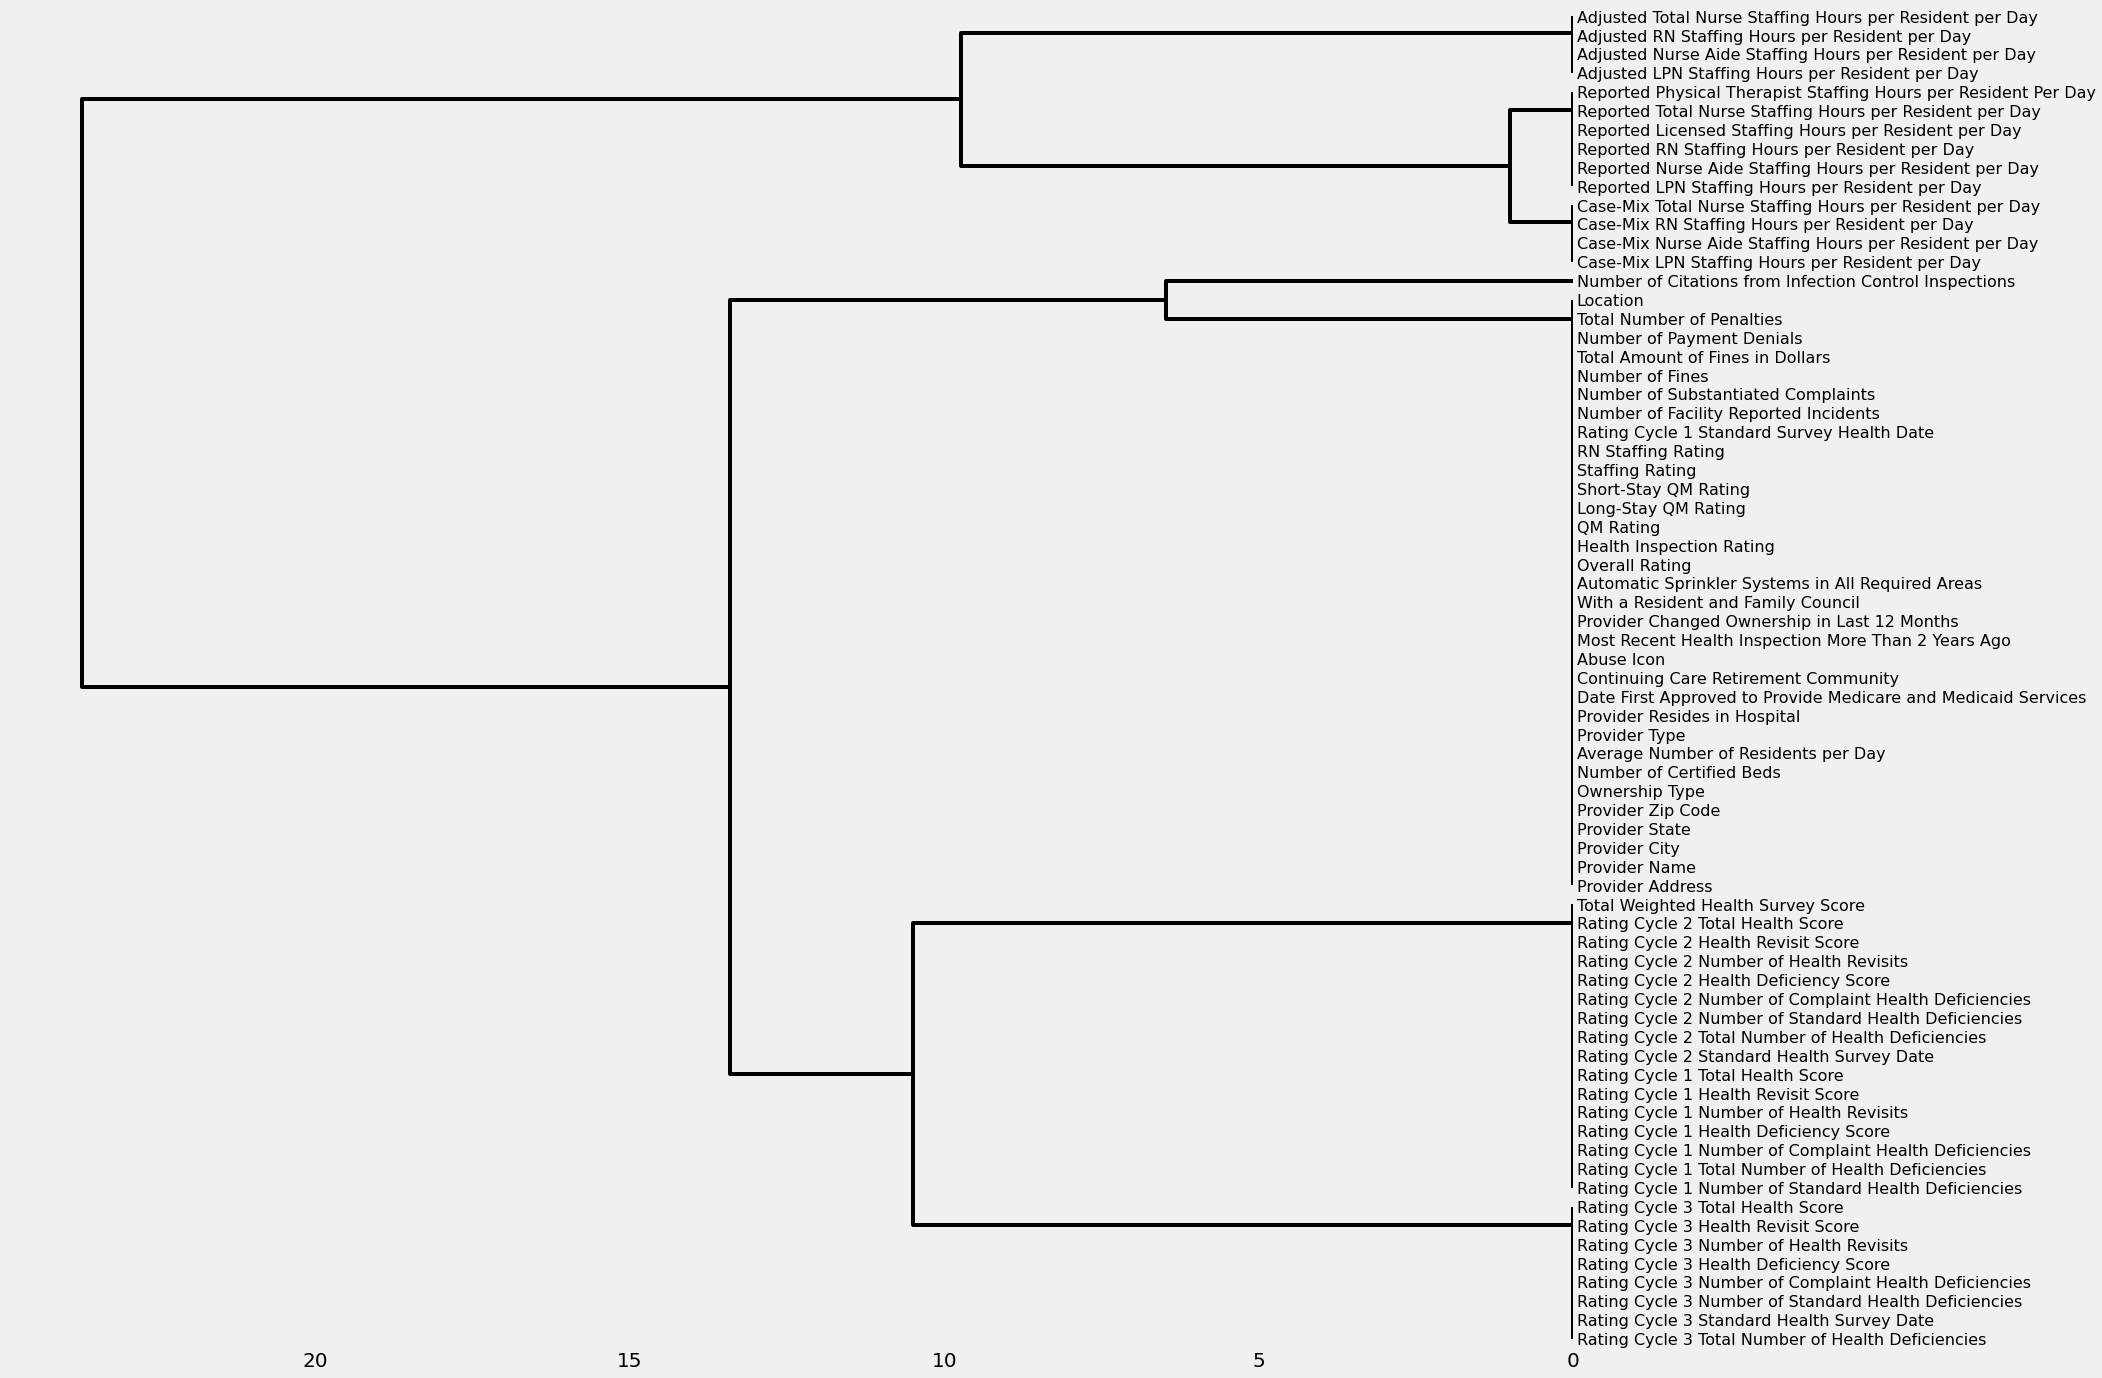

In [30]:
msno.dendrogram(information)
plt.show()

The dendrogram shows that the distance is between many columns so close. This means that the NaN appears several columns on each row.

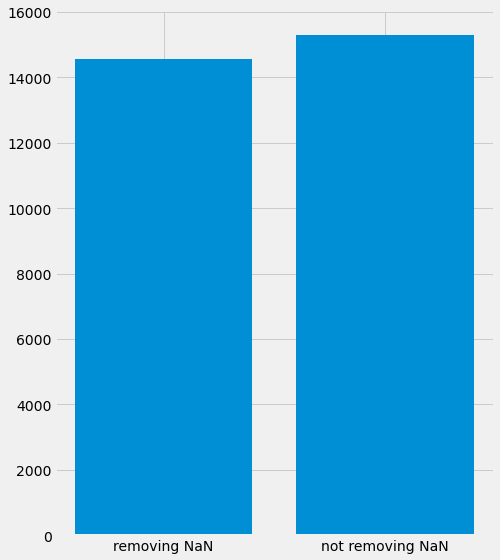

In [31]:
# What if removing NaN in each row?
guinea_pig = information[~information.isnull().values.any(axis=1)].copy()
plt.figure(figsize=(7,9))
plt.bar(['removing NaN','not removing NaN'],[len(guinea_pig),len(information)])
plt.show()

In [32]:
# Now removing NaN
information = information[~information.isnull().values.any(axis=1)]

In [33]:
print('The number of missings is:',information.isnull().any(axis = 1).sum())

The number of missings is: 0


### Automation to Convert Dtypes <a id = 'dtypes'></a>

In [34]:
# Create automation to identify types that should be categorical
def multi_categorical(data, threshold):
    guinea_pig = data.copy()
    for i in guinea_pig.columns:
        if (len(guinea_pig[i].unique()) < threshold) and (guinea_pig[i].dtypes == pd.DataFrame(['a']).dtypes):
            guinea_pig[i] = guinea_pig[i].astype('category')
    return guinea_pig

In [35]:
guinea_pig = information.copy()
thelist = []
for i in range(0,53):
    thelist.append(len(multi_categorical(guinea_pig, i).select_dtypes(include = 'category').columns))

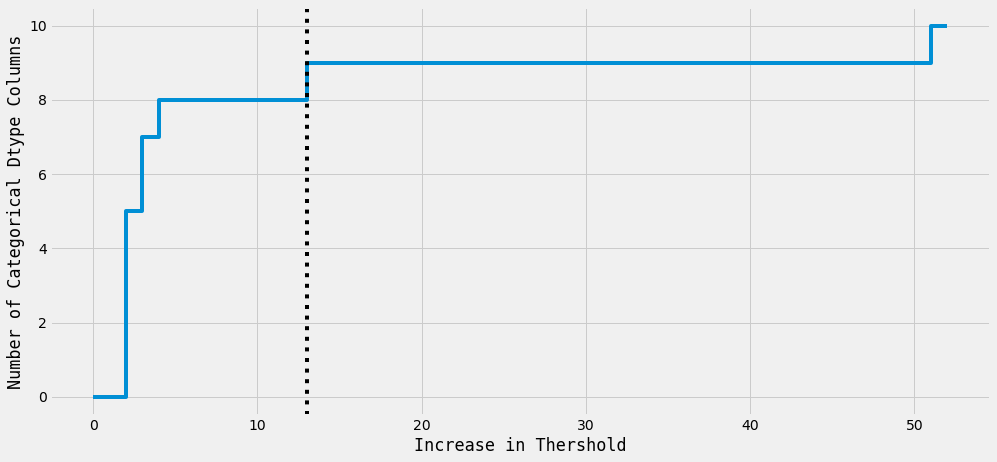

In [36]:
plt.figure(figsize=(15,7))
plt.plot(pd.DataFrame(thelist),drawstyle='steps')
plt.ylabel('Number of Categorical Dtype Columns',family='monospace')
plt.xlabel('Increase in Thershold',family='monospace')
plt.axvline(13,linestyle=':',color='black')
plt.show()

In [37]:
# Select 6 as a threshold for labelling categories
information = multi_categorical(information, 14)

In [38]:
display(information.select_dtypes(include = 'category').head())

,Ownership Type,Provider Type,Provider Resides in Hospital,Continuing Care Retirement Community,Abuse Icon,Most Recent Health Inspection More Than 2 Years Ago,Provider Changed Ownership in Last 12 Months,With a Resident and Family Council,Automatic Sprinkler Systems in All Required Areas
27,For profit - Corporation,Medicare and Medicaid,N,N,N,N,N,Resident,Yes
31,For profit - Corporation,Medicare and Medicaid,N,N,Y,N,N,Resident,Yes
35,For profit - Limited Liability company,Medicare and Medicaid,N,N,N,N,N,Resident,Yes
36,For profit - Corporation,Medicare and Medicaid,N,N,N,N,N,Resident,Yes
41,For profit - Corporation,Medicare and Medicaid,N,N,N,N,N,Resident,Yes


In [39]:
# Too many uniques
print(information['Ownership Type'].unique())

['For profit - Corporation', 'For profit - Limited Liability company', 'For profit - Partnership', 'Non profit - Corporation', 'For profit - Individual', ..., 'Non profit - Church related', 'Non profit - Other', 'Government - City/county', 'Government - City', 'Government - Federal']
Length: 13
Categories (13, object): ['For profit - Corporation', 'For profit - Limited Liability company', 'For profit - Partnership', 'Non profit - Corporation', ..., 'Non profit - Other', 'Government - City/county', 'Government - City', 'Government - Federal']


In [40]:
# Reduce the number of uniques by for profit, non profit, and gov't
information['Ownership Type'] = information['Ownership Type'].apply(lambda x: 'for profit' if 'For profit' in x else 
                                      ('non profit' if 'Non profit' in x else ('government' if 'Government'
                                        in x else x)))

In [41]:
print(information['Ownership Type'].unique())

['for profit' 'non profit' 'government']


### Heatmap: Numeric Variables <a id = 'heatmap'></a>

In [42]:
# Get dummies
def multi_get_dummies(data):
    # Automate to get dummies across many columns 
    for i in data.select_dtypes(include = 'category').columns:
        # If number of types is equal to 2
        if len(data[i].unique()) == 2:
            dummy = pd.get_dummies(data[i],drop_first = True)
            data = pd.concat([data.drop(i,axis = 1),
                              dummy.rename(columns = {list(dummy.columns)[0]:i})],axis=1)
        # If number if types is not equal to 2
        else:
            dummy = pd.get_dummies(data[i], drop_first = True)
            for j in dummy.columns:
                thename = str(i+': '+j)
                dummy = dummy.rename(columns = {j:thename})
            data = pd.concat([data.drop(i,axis = 1),
                              dummy],axis=1)
    return data

In [43]:
# Get multi dummies
information = multi_get_dummies(information)

In [44]:
print(information.select_dtypes(include = ['float','integer']).shape)

(14546, 65)


In [45]:
# Identify the perfectly correlation
correlated = pd.DataFrame(information.corr().unstack().sort_values())

In [46]:
# Drop all pair of identical variables being correlated
correlated.drop(correlated.tail(len(information.select_dtypes(include = ['float','integer']).columns)).index,
        inplace=True)

In [47]:
# Limit correlated variables that are higher than 0.8 or lower than -0.8
correlated = correlated[(correlated > 0.8) | (correlated < -0.8)]
correlated = correlated[~correlated[0].isna()]
correlated = correlated.unstack(level=-1)

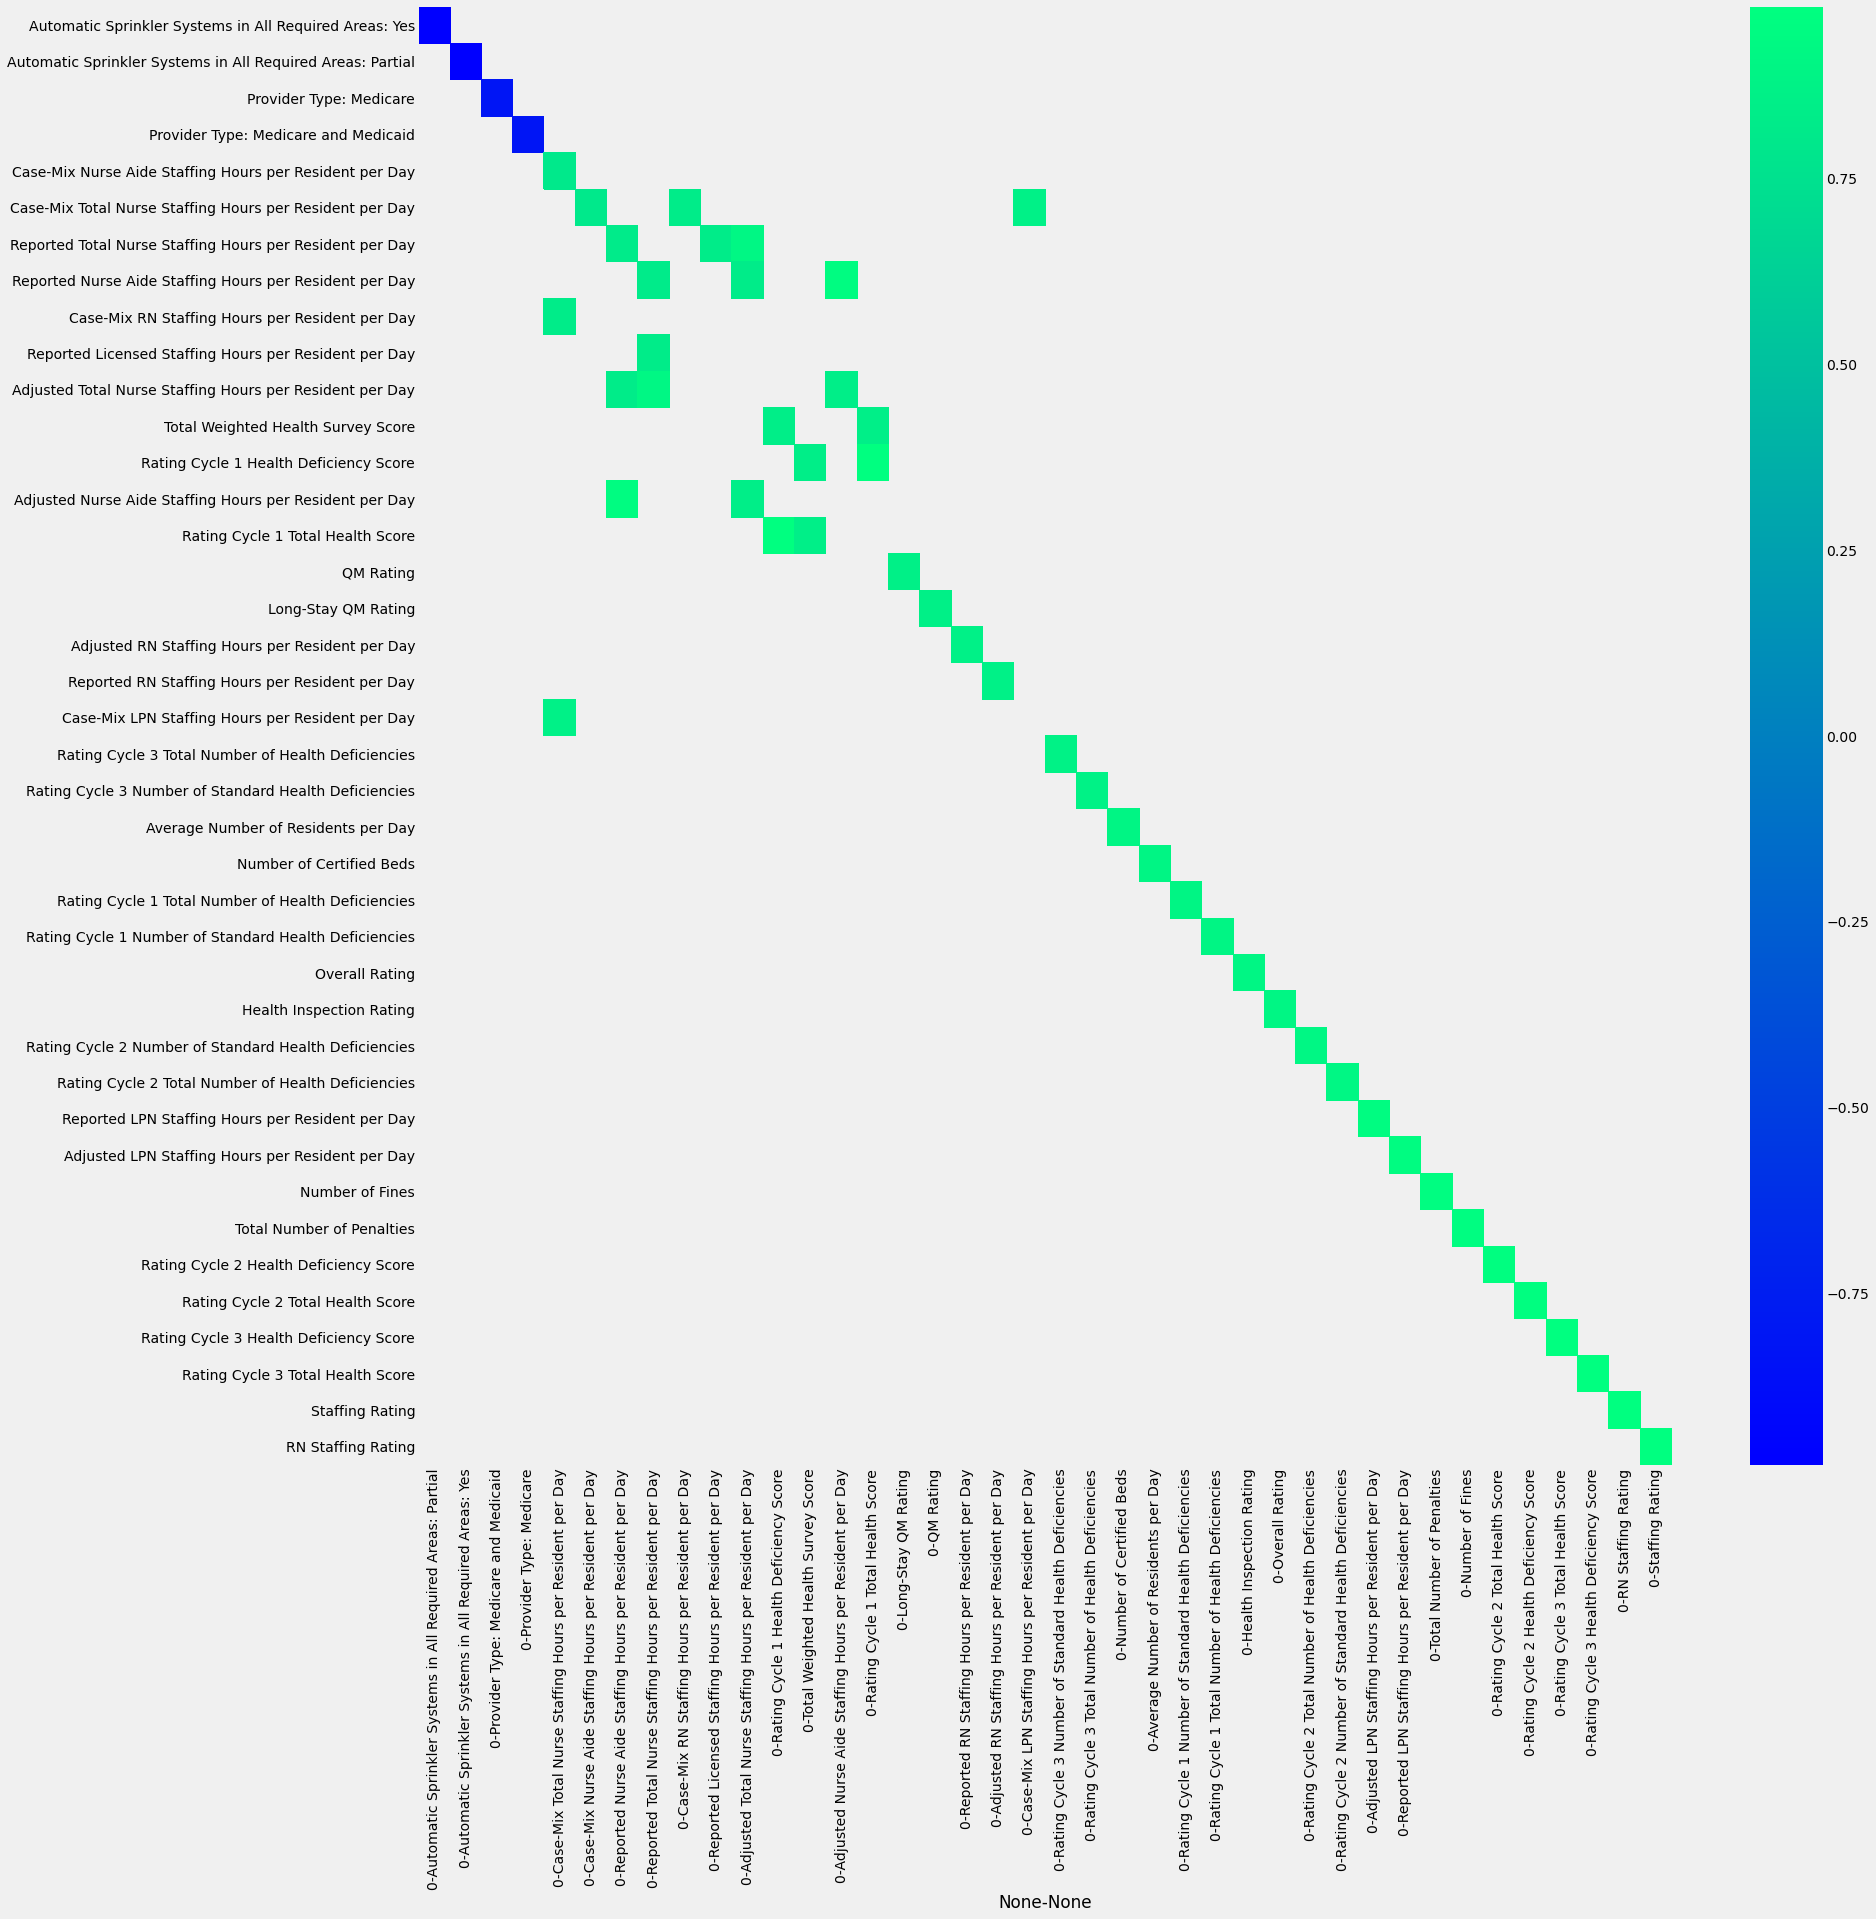

In [48]:
plt.figure(figsize = (25,25))
sns.heatmap(correlated,cmap='winter')
plt.show()

### State PCA <a id = 'pca1'></a>

In [49]:
# Select only float and int but not zip code plus state
df = pd.concat([information['Provider State'],information.select_dtypes(include = ['float',
                                    'integer']).drop('Provider Zip Code',axis=1)],axis=1)
# Group state by mean and store score in another place
df = df.groupby('Provider State').mean()
score = df['Overall Rating']/100
df = df.drop('Overall Rating', axis = 1)

In [50]:
# PCA fit transform
pca = PCA().fit(df)

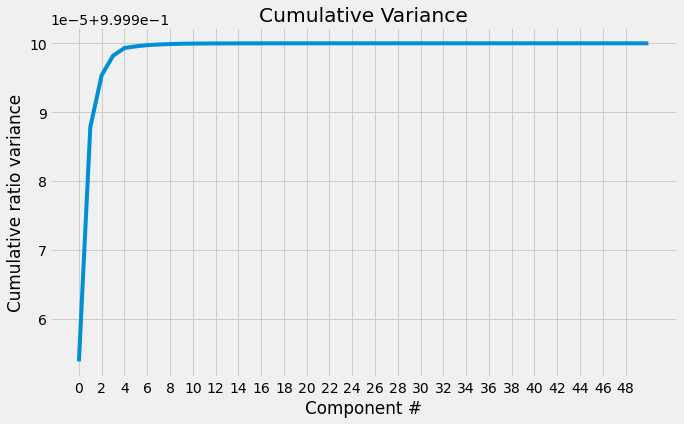

In [51]:
plt.subplots(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative Variance')
plt.xticks(np.arange(0,50,step=2))
plt.show()

In [52]:
# Transform df into pca df
pca_df = pd.DataFrame(pca.transform(df), index = list(df.index))

# Change from 0 - 15 to pc_1 to pc_16
thelist = []
for i in pca_df.columns:
    thelist.append('pc_'+str(i+1))
pca_df.columns = thelist

# Multiply score to make size more visible for plot
pca_df['score'] = score*3000

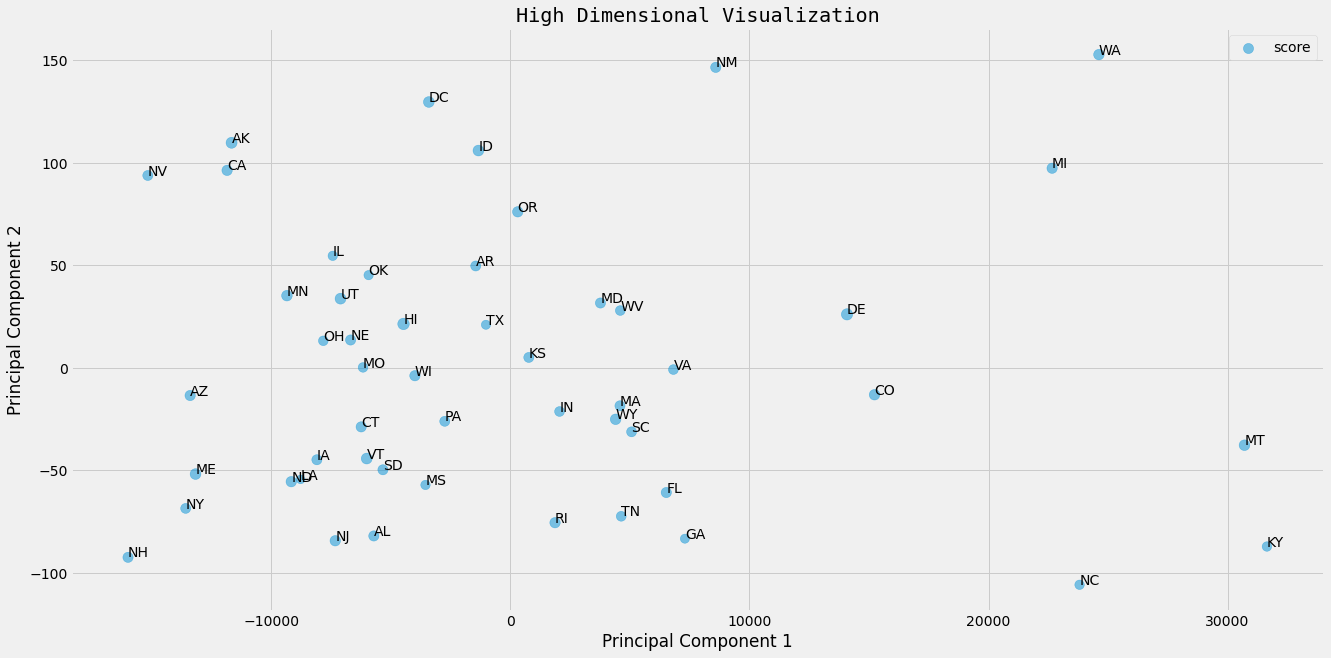

In [53]:
x = pca_df.pc_1
y = pca_df.pc_2
state = pca_df.index
plt.subplots(figsize=(20,10))
plt.scatter('pc_1','pc_2', s = 'score', data=pca_df, alpha=0.5, label = 'score')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('High Dimensional Visualization',family = 'monospace')
plt.legend()
plt.show()

### Uniform Distribution Testing <a id = 'edf1'></a>

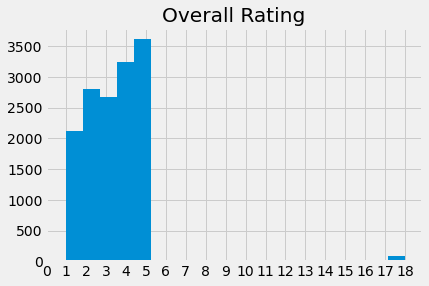

In [54]:
plt.hist(information['Overall Rating'],bins=20)
plt.title('Overall Rating')
plt.xticks(np.arange(0,19,step=1))
plt.show()

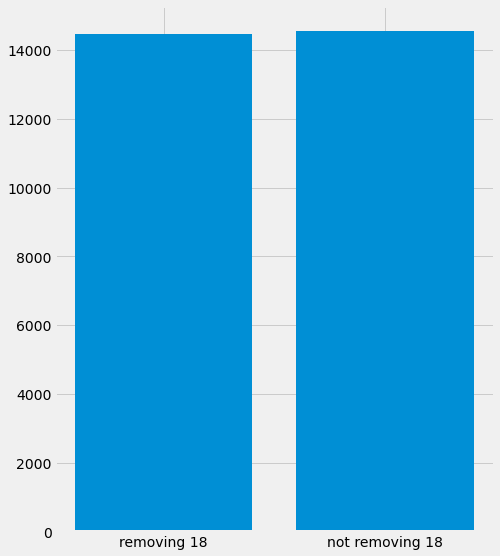

In [55]:
# What if removing NaN in each row?
guinea_pig = information[~information.isnull().values.any(axis=1)].copy()
plt.figure(figsize=(7,9))
plt.bar(['removing 18','not removing 18'],[len(information[information['Overall Rating'] != 18]),
                                             len(information)])
plt.show()

In [56]:
information = information[information['Overall Rating'] != 18]

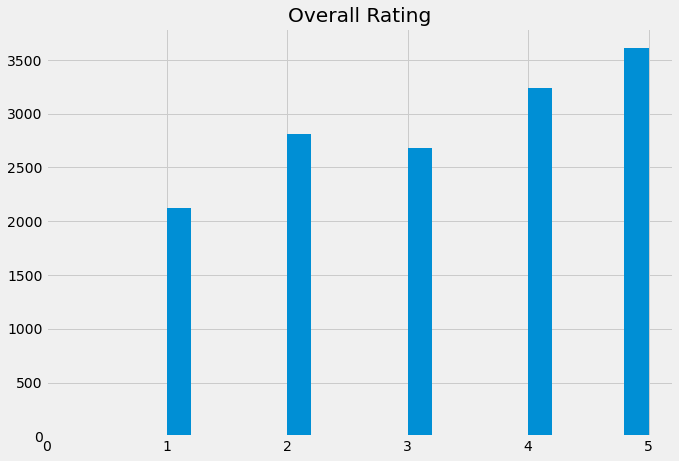

In [57]:
plt.figure(figsize=(10,7))
plt.hist(information['Overall Rating'],bins=20)
plt.title('Overall Rating')
plt.xticks(np.arange(0,6,step=1))
plt.show()

In [58]:
obs = list(Counter(information['Overall Rating']).values())
e = sum(obs)/len(obs)
e = np.repeat(e,len(obs))

In [59]:
print(stats.chisquare(f_obs = obs,f_exp = e, ddof = 1))

Power_divergenceResult(statistic=447.28111172566366, pvalue=1.2657231687327215e-96)


As indicated by above, the difference between observed values and expected values of `Overall Rating` is significant at 0.05 alpha level. The expected distribution should be uniform but the hypothesis proves otherwise.

In [60]:
information.to_csv('cleaned_information.csv')
clean_quality.to_csv('cleaned_quality.csv')